In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11389627520351504203
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17132403038259119192
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy/residential_power_usage_2016_to_2020.csv')
df.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [8]:
df.tail()

,StartDate,Value (kWh),day_of_week,notes
35947,2020-07-07 19:00:00,1.307,1,weekday
35948,2020-07-07 20:00:00,2.872,1,weekday
35949,2020-07-07 21:00:00,2.138,1,weekday
35950,2020-07-07 22:00:00,2.199,1,weekday
35951,2020-07-07 23:00:00,1.809,1,weekday


In [9]:
df.shape

(35952, 4)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    35952 non-null  object 
 1   Value (kWh)  35952 non-null  float64
 2   day_of_week  35952 non-null  int64  
 3   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [11]:
df.isnull().sum()

StartDate      0
Value (kWh)    0
day_of_week    0
notes          0
dtype: int64

In [12]:
time = pd.date_range(start='1/1/2016 00:00:00',periods=35952,freq='H')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['StartDate','day_of_week','notes'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [13]:
df.columns=['value']

In [14]:
df.shape

(35952, 1)

In [15]:
df.head()

,value
time_stamp,
2016-01-01 00:00:00,1.057
2016-01-01 01:00:00,1.171
2016-01-01 02:00:00,0.560
2016-01-01 03:00:00,0.828
2016-01-01 04:00:00,0.932


In [16]:
df.tail()

,value
time_stamp,
2020-02-06 19:00:00,1.307
2020-02-06 20:00:00,2.872
2020-02-06 21:00:00,2.138
2020-02-06 22:00:00,2.199
2020-02-06 23:00:00,1.809


In [17]:
plt.rcParams['figure.figsize'] = [15,8]

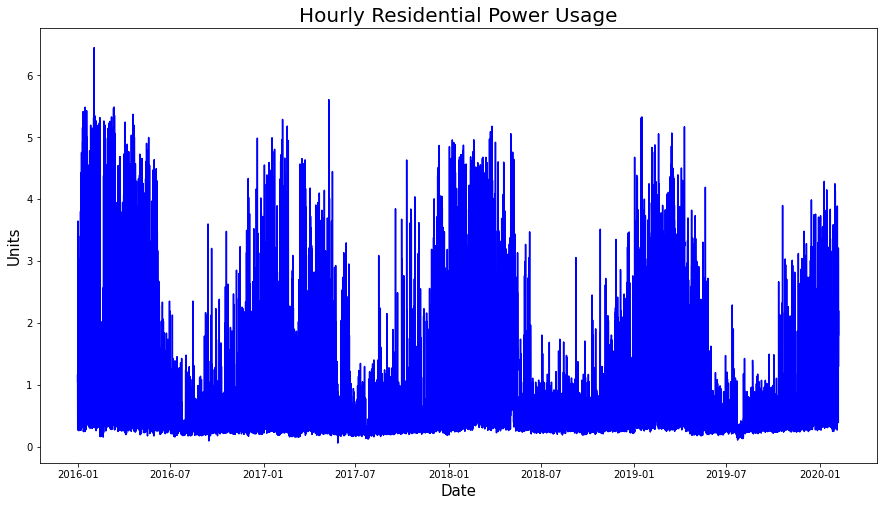

In [18]:
plt.plot(df,color='blue')
plt.title('Hourly Residential Power Usage',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [19]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [20]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['value'] = df['value'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [21]:
#Split data set into testing dataset and train dataset
train_size = 32000
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 23
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [22]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(31977, 23)
(31977,)
(3929, 23)
(3929,)


In [23]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 4.3 MB/s 


In [24]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 256,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=1,
    directory='project',
    project_name='resident_consum_1')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=36,
             validation_data=(testX, testY))

In [ ]:
tuner.results_summary()

Results summary
Results in project/resident_consum_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 6
units_0: 56
dropout: False
learning_rate: 0.005735984373913224
Dropout_rate: 0.5
units_1: 192
units_2: 184
units_3: 136
units_4: 184
units_5: 8
Score: 27.22334098815918
Trial summary
Hyperparameters:
num_layers: 3
units_0: 96
dropout: False
learning_rate: 0.010292914465806513
Dropout_rate: 0.0
units_1: 200
units_2: 16
units_3: 32
units_4: 176
units_5: 232
units_6: 80
units_7: 96
units_8: 152
Score: 27.268409729003906
Trial summary
Hyperparameters:
num_layers: 4
units_0: 24
dropout: False
learning_rate: 0.002901086622163988
Dropout_rate: 0.30000000000000004
units_1: 8
units_2: 240
units_3: 64
units_4: 248
units_5: 104
units_6: 160
units_7: 144
units_8: 224
Score: 27.408287048339844
Trial summary
Hyperparameters:
num_layers: 3
units_0: 200
dropout: False
learning_rate: 0.0015750366262371192
Dropout_rate: 0.4
units_1: 160
unit

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 24))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                1400      
                                                                 
 dense_1 (Dense)             (None, 192)               10944     
                                                                 
 dense_2 (Dense)             (None, 184)               35512     
                                                                 
 dense_3 (Dense)             (None, 136)               25160     
                                                                 
 dense_4 (Dense)             (None, 184)               25208     
                                                                 
 dense_5 (Dense)             (None, 8)                 1480      
                                                                 
 dense_6 (Dense)             (None, 1)                 9

In [25]:
from tensorflow.keras import optimizers

In [26]:
model = Sequential()
model.add(Dense(16,activation='relu',input_dim = 23))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.000095984373913224)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 36, epochs = 300)

Epoch 1/300
889/889 [==============================] - 7s 4ms/step - loss: 38.2075 - mape: 38.2075 - val_loss: 25.9150 - val_mape: 25.9150
Epoch 2/300
889/889 [==============================] - 3s 4ms/step - loss: 25.5871 - mape: 25.5871 - val_loss: 21.5768 - val_mape: 21.5768
Epoch 3/300
889/889 [==============================] - 3s 4ms/step - loss: 20.7580 - mape: 20.7580 - val_loss: 17.8442 - val_mape: 17.8442
Epoch 4/300
889/889 [==============================] - 3s 4ms/step - loss: 18.0995 - mape: 18.0995 - val_loss: 16.1347 - val_mape: 16.1347
Epoch 5/300
889/889 [==============================] - 3s 4ms/step - loss: 16.7116 - mape: 16.7116 - val_loss: 15.2960 - val_mape: 15.2960
Epoch 6/300
889/889 [==============================] - 3s 4ms/step - loss: 15.7979 - mape: 15.7979 - val_loss: 14.4731 - val_mape: 14.4731
Epoch 7/300
889/889 [==============================] - 3s 4ms/step - loss: 15.1659 - mape: 15.1659 - val_loss: 13.9563 - val_mape: 13.9563
Epoch 8/300
889/889 [======

In [27]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [28]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 13.25 
Test MAPE : 12.83 


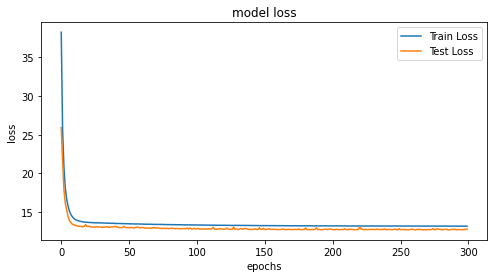

In [29]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [30]:
import seaborn as sns

In [31]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(31977,35906)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

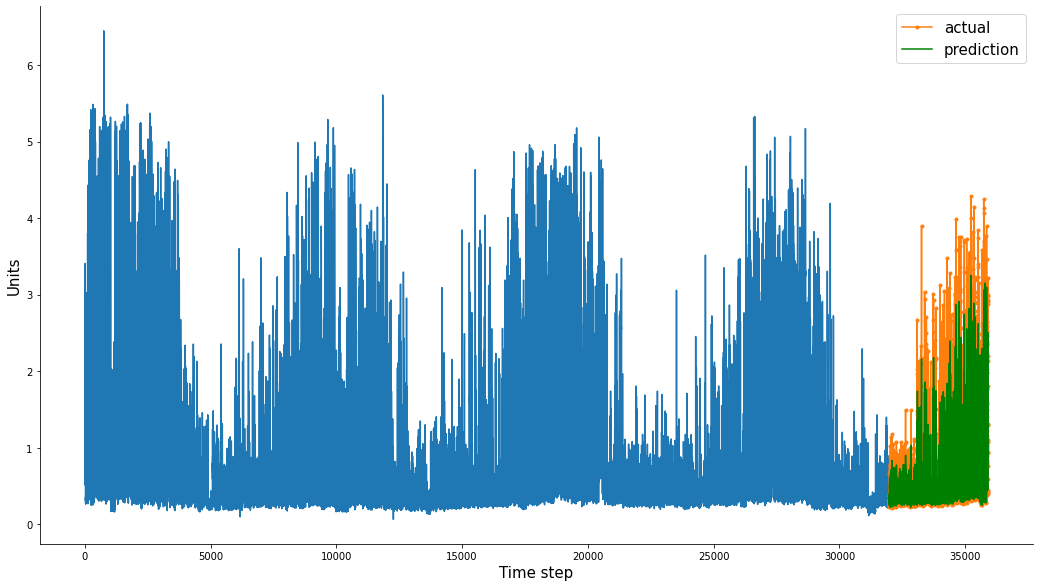

In [32]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)